In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [97]:
df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv')

In [98]:
df['Sample Date'] = pd.to_datetime(df['Sample Date'], errors='coerce')
df = df.dropna(subset=['Sample Date'])  # drop if date conversion failed

# Extract time components
df['Month'] = df['Sample Date'].dt.month
df['Year'] = df['Sample Date'].dt.year
df['Season'] = df['Month'].apply(lambda x: 'Warm' if x in [6, 7, 8, 9] else 'Cold')

# Convert lead columns to numeric
lead_cols = ['1st Draw', '2/3 Min', '5 Min', 'Max']
for col in lead_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Median lead levels by month
monthly_medians = df.groupby('Month')[lead_cols].median()
print(monthly_medians)

# Median lead levels by season
seasonal_medians = df.groupby('Season')[lead_cols].median()
print(seasonal_medians)

       1st Draw  2/3 Min  5 Min  Max
Month                               
1           1.6      1.2    0.5  2.1
2           2.0      1.7    0.6  2.7
3           2.0      1.9    0.8  2.7
4           1.9      2.0    1.1  2.7
5           1.8      2.0    1.2  2.7
6           2.0      2.3    1.5  3.0
7           2.2      2.7    1.8  3.4
8           2.2      2.6    1.8  3.2
9           2.3      2.7    1.8  3.5
10          2.1      2.4    1.5  3.0
11          1.8      1.7    1.1  2.5
12          1.8      1.4    0.6  2.3
        1st Draw  2/3 Min  5 Min  Max
Season                               
Cold         1.9      1.8    1.0  2.6
Warm         2.2      2.6    1.7  3.3


In [99]:
df['Sample Date'] = pd.to_datetime(df['Sample Date'], errors='coerce')
df = df.dropna(subset=['Sample Date'])  # drop if date conversion failed

# Extract time components
df['Month'] = df['Sample Date'].dt.month
df['Year'] = df['Sample Date'].dt.year
df['Season'] = df['Month'].apply(lambda x: 'Warm' if x in [6, 7, 8, 9] else 'Cold')

# Convert lead columns to numeric
lead_cols = ['1st Draw', '2/3 Min', '5 Min', 'Max']
for col in lead_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Median lead levels by month
monthly_medians = df.groupby('Month')[lead_cols].mean()
print(monthly_medians)

# Median lead levels by season
seasonal_medians = df.groupby('Season')[lead_cols].mean()
print(seasonal_medians)

       1st Draw   2/3 Min      5 Min        Max
Month                                          
1      4.169805  3.378449   1.508135   5.681356
2      5.174270  3.382382   1.542268   6.563880
3      5.512456  4.129071   1.832157   7.476250
4      3.825598  4.466494   2.108320   5.843766
5      3.769448  4.170219   2.244721   5.713358
6      4.791282  5.292882   3.068127   7.657380
7      4.758783  5.155711   2.919218   7.181074
8      6.078307  4.851624   2.903764   8.370757
9      7.409592  8.705800  17.576010  21.831355
10     4.946231  5.012813   2.626484   7.384557
11     8.663733  4.867964   2.037497  10.520722
12     4.947590  7.226195   4.063894   9.379635
        1st Draw   2/3 Min     5 Min        Max
Season                                         
Cold    5.198305  4.583465  2.235578   7.366690
Warm    5.778689  5.937776  6.420166  11.101686


seasonality is confirmed

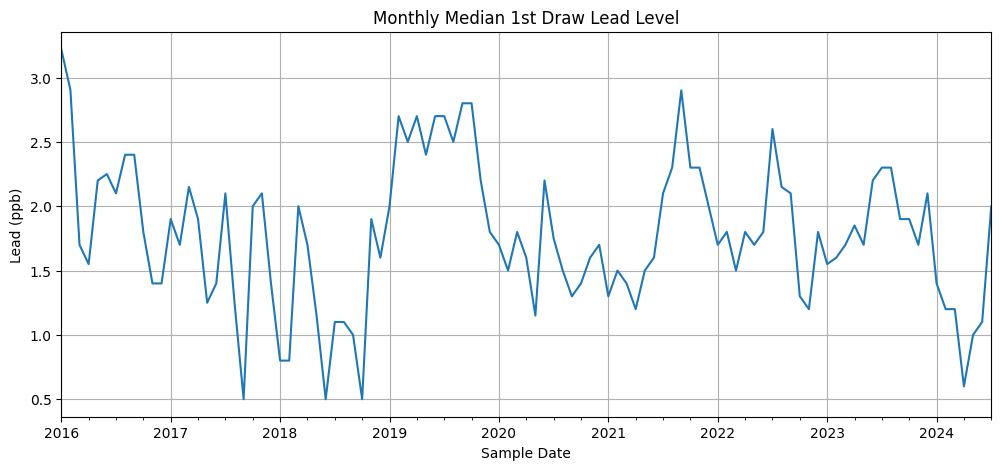

In [100]:
# Monthly median aggregation for 1st Draw
monthly_df = df.set_index('Sample Date').resample('M')['1st Draw'].median().dropna()

# Quick plot to visualize trend
import matplotlib.pyplot as plt

monthly_df.plot(title='Monthly Median 1st Draw Lead Level', ylabel='Lead (ppb)', figsize=(12, 5))
plt.grid()
plt.show()

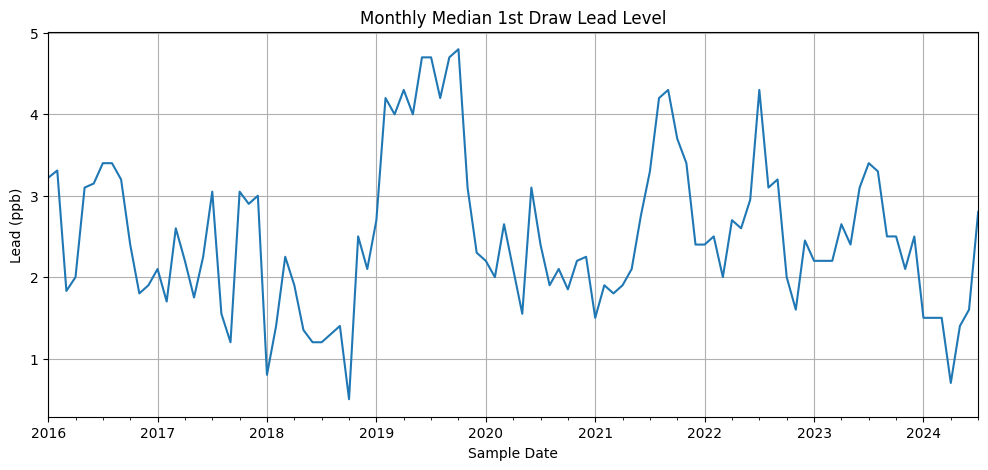

In [101]:
# Monthly median aggregation for 1st Draw
monthly_df = df.set_index('Sample Date').resample('M')['Max'].median().dropna()

# Quick plot to visualize trend
import matplotlib.pyplot as plt

monthly_df.plot(title='Monthly Median 1st Draw Lead Level', ylabel='Lead (ppb)', figsize=(12, 5))
plt.grid()
plt.show()

In [102]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_df)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  # p-value less than 0.001 and ADF = -4,1, stationarity confirmed

ADF Statistic: -4.09791897982136
p-value: 0.0009762240818394352


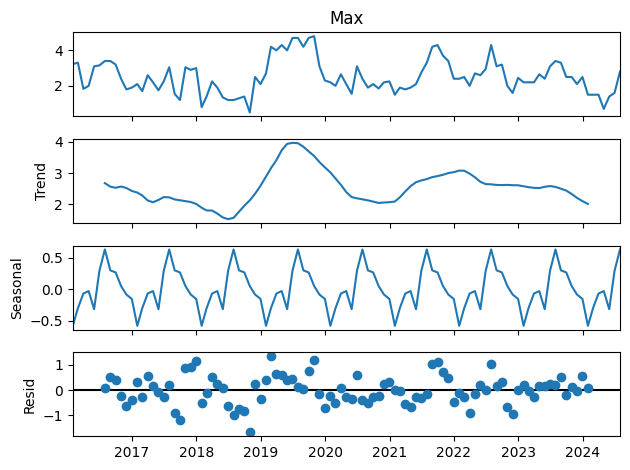

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(monthly_df, model='additive')
decomp.plot()
plt.show()


In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA(p=1, d=0, q=1)(P=1, D=1, Q=1, s=12)
model = SARIMAX(monthly_df,
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())



                                     SARIMAX Results                                      
Dep. Variable:                                Max   No. Observations:                  103
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -82.658
Date:                            Tue, 08 Apr 2025   AIC                            175.316
Time:                                    23:01:31   BIC                            187.035
Sample:                                01-31-2016   HQIC                           180.003
                                     - 07-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8040      0.080     10.076      0.000       0.648       0.960
ma.L1         -0.1252      0.133   

AIC = 175.31 – Lower AIC is better, and this looks pretty solid for 103 obs.

ar.L1 (0.804) – Strong autoregressive effect: current value influenced by the previous one.

ma.L1 (-0.125) – Not significant (p=0.345), maybe could be dropped in future tuning.

Seasonal terms significant:

ar.S.L12 = -0.401, ma.S.L12 = -0.617 → captures yearly seasonality, and both are significant (p < 0.01).

sigma² = 0.467 → Variance of residuals.

📊 Model checks (at bottom):

Ljung-Box p = 0.92 → No autocorrelation left in residuals ✅

Jarque-Bera p = 0.37 → Residuals look kinda normal ✅

Heteroskedasticity p = 0.06 → Might be slightly heteroskedastic, but not a dealbreaker.

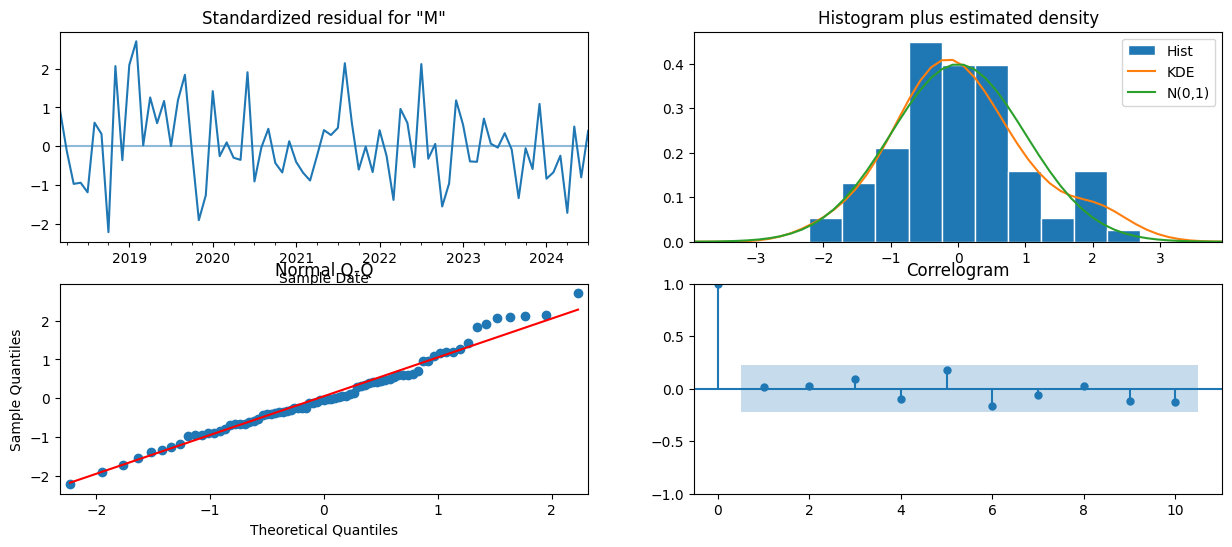

In [105]:
results.plot_diagnostics(figsize=(15, 6))
plt.show()


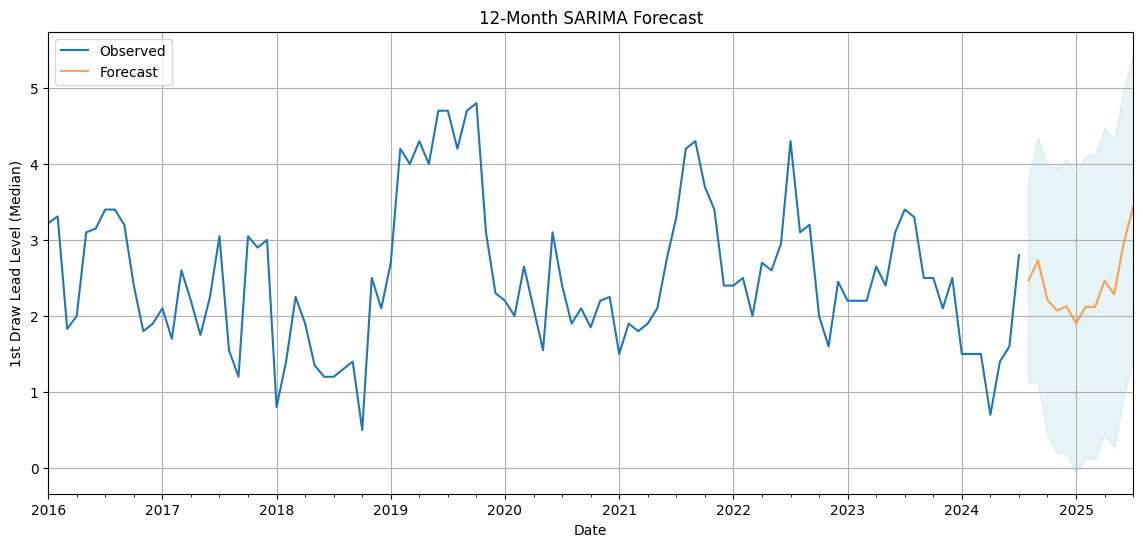

In [106]:
pred = results.get_forecast(steps=12)
pred_ci = pred.conf_int()

ax = monthly_df.plot(label='Observed', figsize=(14, 6))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='lightblue', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('1st Draw Lead Level (Median)')
plt.legend()
plt.title("12-Month SARIMA Forecast")
plt.grid()
plt.show()


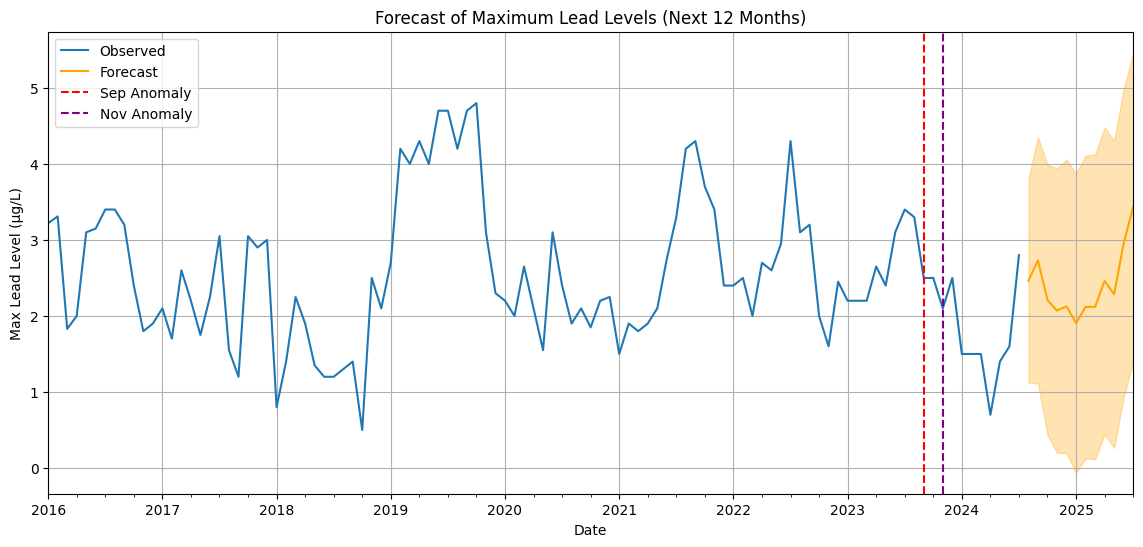

In [107]:
monthly_max = monthly_df.copy()
monthly_max.name = 'Max'  # Ensure it has a name, useful for legend

forecast = results.get_forecast(steps=12)
ci = forecast.conf_int()

# Plot original and forecast
ax = monthly_max.plot(label='Observed', figsize=(14, 6))
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='orange')
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='orange', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Max Lead Level (µg/L)')
ax.set_title('Forecast of Maximum Lead Levels (Next 12 Months)')
plt.axvline(pd.to_datetime('2023-09-30'), color='red', linestyle='--', label='Sep Anomaly')
plt.axvline(pd.to_datetime('2023-11-30'), color='purple', linestyle='--', label='Nov Anomaly')
plt.legend()
plt.grid()
plt.show()


In [108]:
seasonal_avg = pd.DataFrame({
    'Season': ['Cold', 'Warm'],
    'Max': [7.366690, 11.101686]
})


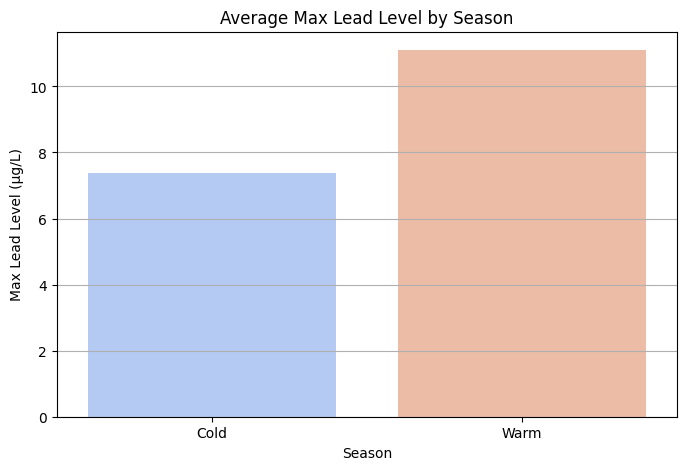

In [109]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=seasonal_avg, x='Season', y='Max', palette='coolwarm')
plt.title('Average Max Lead Level by Season')
plt.ylabel('Max Lead Level (µg/L)')
plt.grid(axis='y')
plt.show()


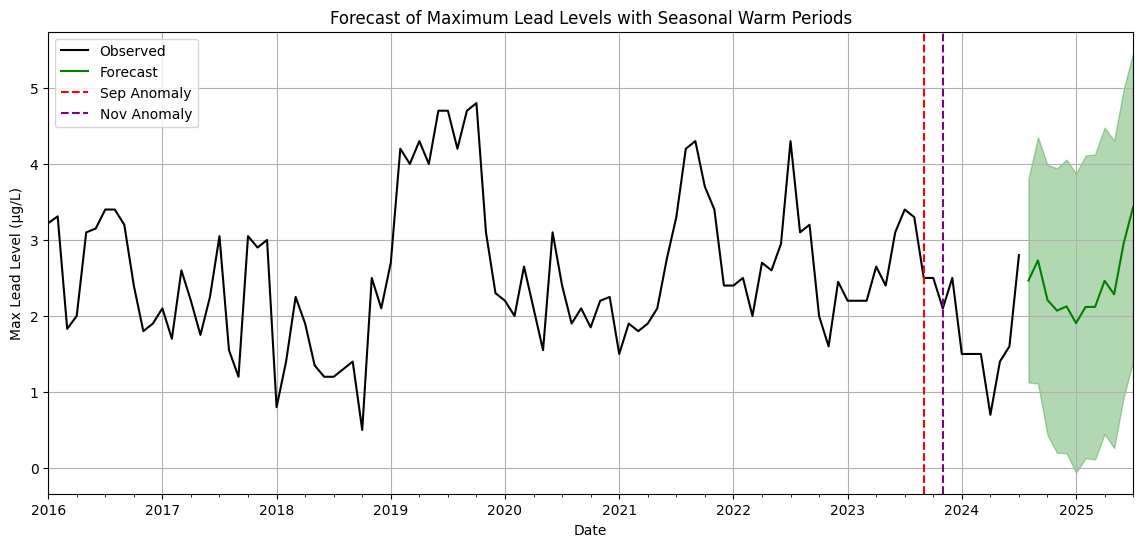

In [110]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot warm season bands
for year in range(2016, 2025):
    ax.axvspan(pd.to_datetime(f'{year}-05-01'), pd.to_datetime(f'{year}-09-30'),
               color='orange', alpha=0.1)

# Plot time series and forecast
monthly_df.plot(ax=ax, label='Observed', color='black')
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='green')
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='green', alpha=0.3)

# Highlight anomalies
ax.axvline(pd.to_datetime('2023-09-30'), color='red', linestyle='--', label='Sep Anomaly')
ax.axvline(pd.to_datetime('2023-11-30'), color='purple', linestyle='--', label='Nov Anomaly')

# Labels, legend, and grid
ax.set_xlabel('Date')
ax.set_ylabel('Max Lead Level (µg/L)')
ax.set_title('Forecast of Maximum Lead Levels with Seasonal Warm Periods')
ax.legend()
ax.grid(True)

plt.show()


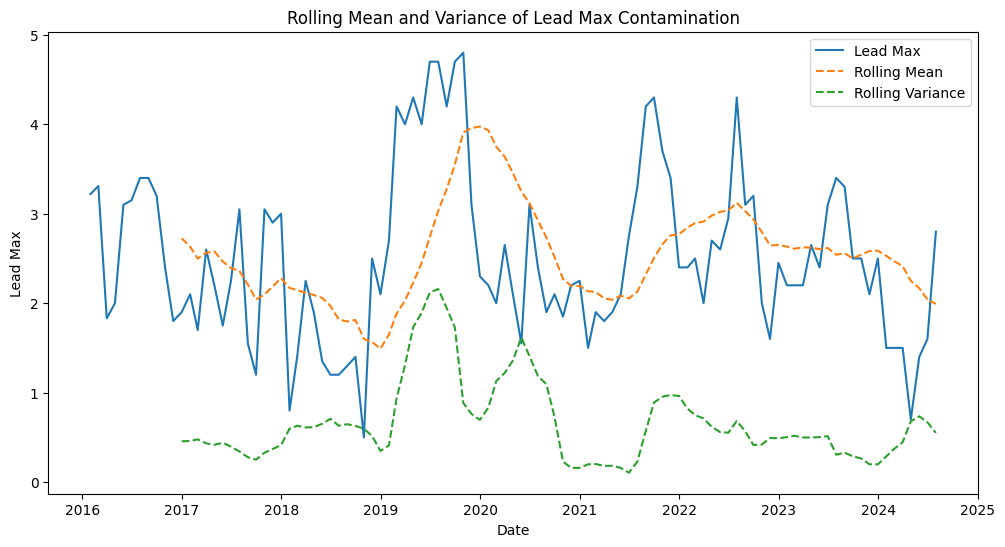

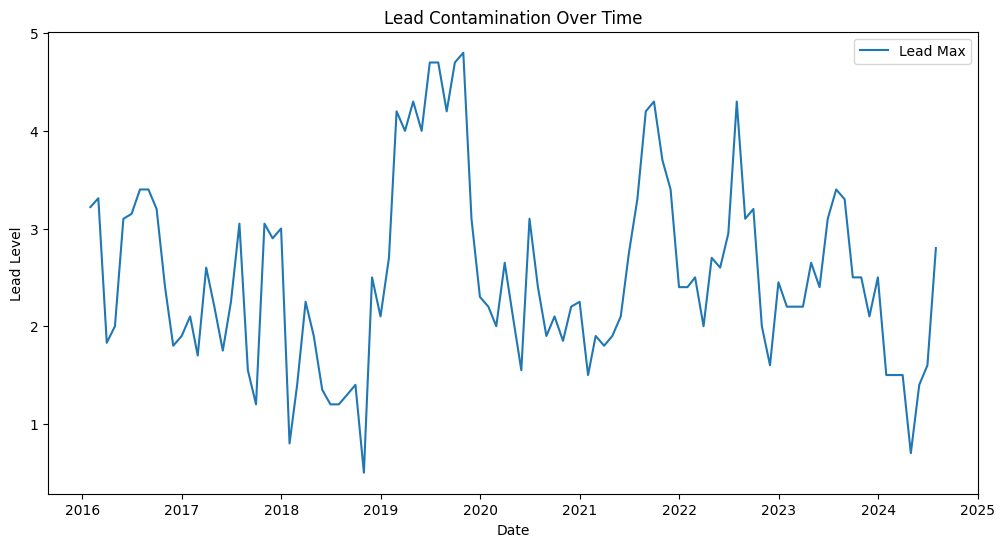

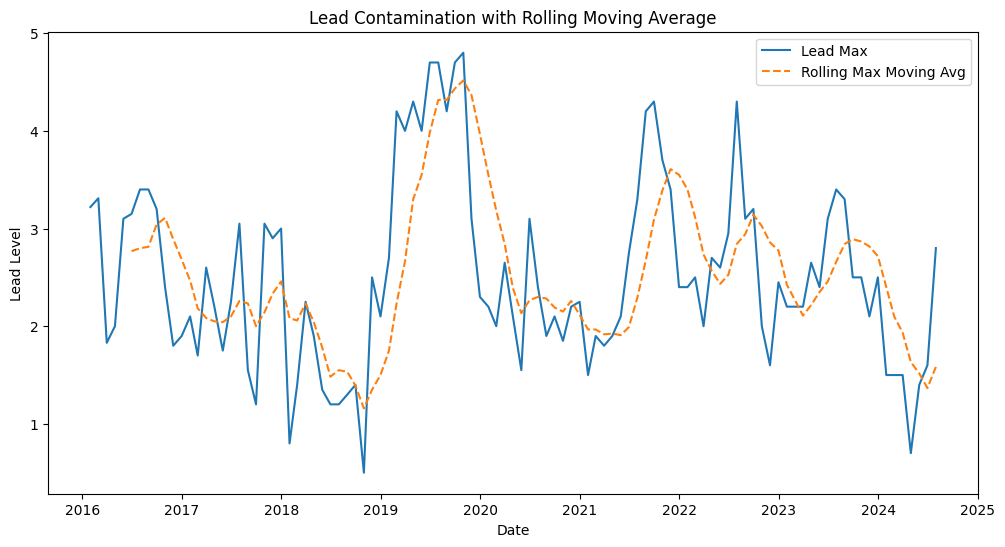

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming monthly_df is already created with 'lead_max' as the column for the maximum lead level

# Plot rolling mean and variance
monthly_df = monthly_df.dropna()  # Drop rows with NaN values (no need for 'subset' argument)

rolling_mean = monthly_df.rolling(window=12).mean()
rolling_variance = monthly_df.rolling(window=12).var()

plt.figure(figsize=(12, 6))
plt.plot(monthly_df.index, monthly_df, label='Lead Max')
plt.plot(monthly_df.index, rolling_mean, label='Rolling Mean', linestyle='--')
plt.plot(monthly_df.index, rolling_variance, label='Rolling Variance', linestyle='--')
plt.legend()
plt.title('Rolling Mean and Variance of Lead Max Contamination')
plt.xlabel('Date')
plt.ylabel('Lead Max')
plt.show()

# Plot Max Lead Contamination over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_df.index, monthly_df, label='Lead Max')
plt.title('Lead Contamination Over Time')
plt.xlabel('Date')
plt.ylabel('Lead Level')
plt.legend()
plt.show()

# Add moving averages to the trend plot
rolling_max = monthly_df.rolling(window=6).mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_df.index, monthly_df, label='Lead Max')
plt.plot(monthly_df.index, rolling_max, label='Rolling Max Moving Avg', linestyle='--')
plt.title('Lead Contamination with Rolling Moving Average')
plt.xlabel('Date')
plt.ylabel('Lead Level')
plt.legend()
plt.show()
